In [120]:
import pandas as pd
import torch 

train_data=pd.read_csv("../data/lot/train.csv")
test_data=pd.read_csv("../data/lot/test.csv")


In [121]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [122]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
all_features.iloc[0:4]


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml


In [123]:
import numpy as np
indices=all_features.dtypes[all_features.dtypes != 'object'].index
all_features[indices].apply(
    lambda x: (x-x.mean())/x.std()
)
all_features[indices]=all_features[indices].fillna(0)
all_features=pd.get_dummies(all_features,dummy_na=True)
all_features.iloc[0:4]

arr = all_features.to_numpy(dtype=np.float32)
arr

array([[6.0000e+01, 6.5000e+01, 8.4500e+03, ..., 1.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.0000e+01, 8.0000e+01, 9.6000e+03, ..., 1.0000e+00, 0.0000e+00,
        0.0000e+00],
       [6.0000e+01, 6.8000e+01, 1.1250e+04, ..., 1.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [2.0000e+01, 1.6000e+02, 2.0000e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [8.5000e+01, 6.2000e+01, 1.0441e+04, ..., 1.0000e+00, 0.0000e+00,
        0.0000e+00],
       [6.0000e+01, 7.4000e+01, 9.6270e+03, ..., 1.0000e+00, 0.0000e+00,
        0.0000e+00]], dtype=float32)

In [124]:
n_train=train_data.shape[0]
train_feathures=torch.tensor(arr[:n_train],dtype=torch.float32)
test_features=torch.tensor(arr[n_train:],dtype=torch.float32)
labels=torch.tensor(train_data.SalePrice.values,dtype=torch.float32)
print(labels.sum(),labels.mean(),labels.std())

tensor(2.6414e+08) tensor(180921.2031) tensor(79442.5000)


In [125]:
from torch.utils import data
from torch import nn

def log_rmse(net,loss,feathures,labels):
    clip_pred=torch.clamp(net(feathures),1,float('inf'))
    rmse=torch.sqrt(loss(torch.log(clip_pred),torch.log(labels)))
    return rmse.item()

def get_k_fold_data(k,i,x,y):
    assert k > 1
    fold_size=x.shape[0] // k
    x_train,y_train=None,None
    for j in range(k):
        idx=slice(j*fold_size,(j+1)*fold_size)
        x_part,y_part=x[idx,:],y[idx]
        if i==j:
            x_valid,y_valid=x_part,y_part
        elif x_train is None:
            x_train,y_train=x_part,y_part
        else:
            x_train=torch.cat([x_train,x_part],0)
            y_train=torch.cat([y_train,y_part],0)
    return x_train,y_train,x_valid,y_valid

def data_iter(dds,batch_size):
    ds=data.TensorDataset(*dds)
    return data.DataLoader(ds,batch_size,True)

def init_params(m):
    if type(m)==nn.Linear:
        nn.init.normal_(m.weight,std=0.01)
        nn.init.zeros_(m.bias)

def train(trainx,trainy,k,num_epoch,batch_size,lr,):
    net=nn.Sequential(nn.Linear(trainx.shape[1],1))
    net.apply(init_params)
    train_lls,test_lls=[],[]
    for i in range(k):
        x_train,y_train,x_valid,y_valid=get_k_fold_data(k,i,trainx,trainy)
        train_iter=data_iter((x_train,y_train),batch_size)
        #test_iter=data_iter((x_valid,y_valid),batch_size)
        
        loss=nn.MSELoss()
        updater=torch.optim.Adam(net.parameters(),lr=lr)
        for epoch in range(num_epoch):
            for x,y in train_iter:
                updater.zero_grad()
                y_hat=net(x)
                l=loss(y_hat,y.reshape(y_hat.shape))
                l.backward()
                updater.step()
        with torch.no_grad():
            # train_y_hat=net(x_train)
            # train_loss=loss(train_y_hat,y_train.reshape(train_y_hat.shape))
            trainlog_loss=log_rmse(net,loss,x_train,y_train.reshape(len(y_train),-1))
            train_lls.append(trainlog_loss)
            # test_y_hat=net(x_valid)
            # test_loss=loss(test_y_hat,y_valid.reshape(test_y_hat.shape))
            testlog_loss=log_rmse(net,loss,x_valid,y_valid.reshape(len(y_valid),-1))
            test_lls.append(testlog_loss)
            print(f'fold k:{i} trainlog_loss:{trainlog_loss} testlog_loss:{testlog_loss}')
    return train_lls,test_lls



        

fold k:0 trainlog_loss:0.22330060601234436 testlog_loss:0.2467188984155655
fold k:1 trainlog_loss:0.1632586121559143 testlog_loss:0.18808414041996002
fold k:2 trainlog_loss:0.15672163665294647 testlog_loss:0.16407442092895508
fold k:3 trainlog_loss:0.15183527767658234 testlog_loss:0.13975240290164948
fold k:4 trainlog_loss:0.1363411545753479 testlog_loss:0.15448948740959167


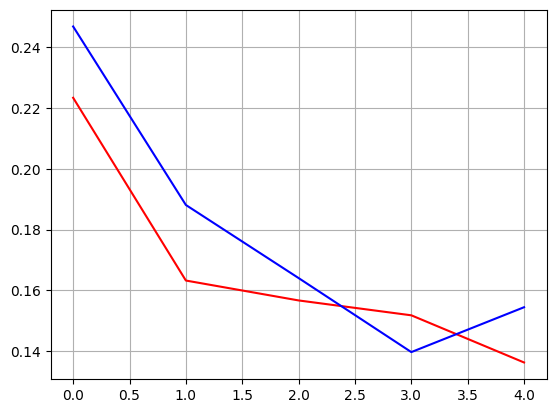

In [126]:
import matplotlib.pyplot as plt
k=5
num_epoch=100
batch_size=64
lr=4
train_lss,test_lls=train(train_feathures,labels,k,num_epoch,batch_size,lr)

plt.plot(range(len(train_lss)),train_lss,'r',label="train")
plt.plot(range(len(test_lls)),test_lls,'b',label="test")
plt.autoscale()
plt.grid()
plt.show()

In [127]:
# from torch import nn
# from torch.utils import data

# lr=4
# epoch_num=1000
# batch_size=300
# num_inputs=train_feathures.shape[1]
# num_hidden=10
# num_output=1

# def init_data(m):
#     if type(m)==nn.Linear:
#         nn.init.normal_(m.weight,std=0.01)
#         nn.init.zeros_(m.bias)

# net=nn.Sequential(nn.Linear(num_inputs,1))
# net.apply(init_data)
# loss=nn.MSELoss()
# updater=torch.optim.Adam(net.parameters(),lr=lr)

# def data_iter(dds,batch_size):
#     ds=data.TensorDataset(*dds)
#     return data.DataLoader(ds,batch_size,True)

# train_iter=data_iter((train_feathures,labels),batch_size)
# for i in range(epoch_num):
#     for x,y in train_iter:
#         updater.zero_grad()
#         y_hat=net(x)
#         l=loss(y_hat,y.reshape(y_hat.shape))
#         l.backward()
#         updater.step()
#     with torch.no_grad():
#         train_x=loss(net(train_feathures),labels.reshape(len(labels),-1))
#         rmse=log_rmse(net,loss,train_feathures,labels.reshape(len(labels),-1))
#         print(f'i:{i} loss:{train_x.sum()} rmse:{rmse}')


